# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 6
### Jonas Lundgren

In [564]:
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
from scipy.stats import multivariate_normal

In [329]:
digits = load_digits()
train_features, test_features, train_labels, test_labels = train_test_split(digits.data, digits.target,
                                                                            test_size=0.3, random_state=42)

train_features /= 16 
test_features /= 16 

In [716]:
class Gaussian_NBC_EM():
    
    def __init__(self, seed = 42, epsilon = 1e-3):
        self.seed = seed
        self.epsilon = epsilon
    
    def log_prob(self, X, mu, sigma2):
        return np.log(1/np.sqrt(2*np.pi*sigma2)) - 1/(2*sigma2) * (X - mu)**2
    
    def prob(self, x, mu, sigma2):        
        return 1/np.sqrt(2*np.pi*sigma2) * np.exp(- 1/(2*sigma2) * (x - mu)**2)
    
    def fit(self, X, K):
        self.K = K
        np.random.seed(self.seed)
        n_samples, n_features = np.shape(X)
        
        prior = np.ones(K)/K
        
        idxs = np.resize(range(K), n_samples)
        np.random.shuffle(idxs)
        
        mu = np.empty([K, n_features])
        sigma2 = np.empty([K, n_features])
        for k in range(K):
            mu[k] = np.mean(X[idxs == k], axis=0)
            sigma2[k] = np.var(X[idxs == k], axis=0)
        
        sigma2 += self.epsilon
        
        P = np.empty([n_samples, K])
        r = np.empty([n_samples, K])
        prev_prior = np.zeros(K)
        
        while np.linalg.norm(prev_prior - prior) > 1e-6:
                             
            # E step
            for k in range(K):
                P[:, k] = np.prod(self.prob(X, mu[k], sigma2[k]), axis = 1)
                
            r = prior * P / (np.sum(prior * P, axis = 1)).reshape(-1,1)
            
            # M step
            r_k = np.sum(r, axis = 0)
            prev_prior = prior #For stop condition
            prior = r_k / np.sum(r_k)
                             
            for k in range(K):
                mu[k] = np.sum(r[:, k].reshape(-1,1) * X, axis = 0) / r_k[k]
                sigma2[k] = np.diag((r[:, k].reshape(-1,1) * (X - mu[k])).T @ (X - mu[k]) / r_k[k])
                   
            sigma2 += self.epsilon
            
        
        self.mu = mu
        self.sigma2 = sigma2
        self.prior = prior
        
    def predict(self, X):
        preds = np.empty(len(X), dtype = np.int32)
        prob = np.zeros(self.K)
        
        for i, x in enumerate(X):
            for k in range(self.K):                
                prob[k] = self.prior[k] * np.prod(self.prob(x, self.mu[k], self.sigma2[k]))
                  
            preds[i] = np.argmax(prob)
        
        self.preds = preds
        return self.preds

In [717]:
em = Gaussian_NBC_EM()
em.fit(train_features, K = 10)

### Train Data

In [718]:
ypreds = em.predict(train_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, ypreds))

Confusion matrix:
[[  0   0 123   0   2   0   0   0   0   0]
 [  0   4   0   0   1  41  61   1   4  20]
 [  0   0   0   0   0   0  14   0  70  46]
 [ 90   3   0   0   0   0  19  12   2   3]
 [  0  10   0   0  99  10   0   1   1   0]
 [  9   4   0   0   0   0   1  68  34   0]
 [  0   0   0 125   1   0   0   2   0   0]
 [  0 116   0   0   0   3   4   1   0   0]
 [  1   1   0   0   2   3  63  49   6   6]
 [ 90   7   0   0   0  14   0   8   1   1]]


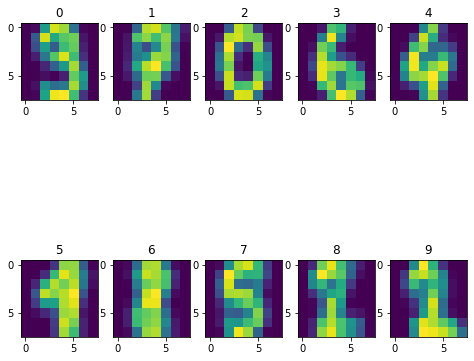

In [719]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(em.mu[i]*16,(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
plt.show()

In [746]:
preds_fix = np.zeros(len(preds))
preds_fix[ypreds == 0] = 3
preds_fix[ypreds == 1] = 7
preds_fix[ypreds == 2] = 0
preds_fix[ypreds == 3] = 6
preds_fix[ypreds == 4] = 4
preds_fix[ypreds == 5] = 9
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 5
preds_fix[ypreds == 8] = 2
preds_fix[ypreds == 9] = 1

In [747]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, preds_fix))

Confusion matrix:
[[123   0   0   0   2   0   0   0   0   0]
 [  0  20   4   0   1   1   0   4  61  41]
 [  0  46  70   0   0   0   0   0  14   0]
 [  0   3   2  90   0  12   0   3  19   0]
 [  0   0   1   0  99   1   0  10   0  10]
 [  0   0  34   9   0  68   0   4   1   0]
 [  0   0   0   0   1   2 125   0   0   0]
 [  0   0   0   0   0   1   0 116   4   3]
 [  0   6   6   1   2  49   0   1  63   3]
 [  0   1   1  90   0   8   0   7   0  14]]


In [748]:
metrics.accuracy_score(train_labels, preds_fix)

0.6268894192521878

# Test Data

In [753]:
ypreds = em.predict(test_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, ypreds))

Confusion matrix:
[[ 1  0 50  0  2  0  0  0  0  0]
 [ 0  2  0  0  1 15 18  2  2 10]
 [ 0  0  0  0  0  0  2  1 25 19]
 [34  0  0  0  0  0  9  7  0  4]
 [ 0  6  0  0 48  5  0  1  0  0]
 [10  2  0  1  0  0  1 39 13  0]
 [ 0  0  0 51  0  0  0  2  0  0]
 [ 0 54  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 20 17  4  2]
 [45  3  0  0  0  5  1  4  1  0]]


In [754]:
preds_fix = np.zeros(len(preds))
preds_fix[ypreds == 0] = 3
preds_fix[ypreds == 1] = 7
preds_fix[ypreds == 2] = 0
preds_fix[ypreds == 3] = 6
preds_fix[ypreds == 4] = 4
preds_fix[ypreds == 5] = 9
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 5
preds_fix[ypreds == 8] = 2
preds_fix[ypreds == 9] = 1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1257 but corresponding boolean dimension is 540